# Visualize Minute Bars, Features, and Alerts

This notebook explores the built 1-minute bars, derived 5m features, and backtest alerts for a symbol.
- Create phase: run scripts to generate artifacts
  - download_data.py → build_minute_bars.py → compute_features.py → run_backtest.py
- Visualize phase: inspect parquet and CSV outputs here.

In [1]:
import sys, os
from pathlib import Path
root = Path.cwd()
if not (root / "splf").exists():
    root = root.parent  # move from notebooks/ to repo root
sys.path.insert(0, str(root))
print("Repo root:", root)

Repo root: /home/thaomeo/tinhn/splf_backtest


In [9]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

from splf.utils.io import load_yaml

cfg = load_yaml(f'{root}/config/config.yaml')
paths = cfg['paths']
uni = cfg.get('universe', {})
symbols = uni.get('symbols') or (uni.get('tier_a', []) + uni.get('tier_b', []) + uni.get('tier_c', []))
symbol = symbols[0] if symbols else 'BTCUSDT'
print(paths)
symbol

{'raw_dir': 'data/raw', 'processed_dir': 'data/processed', 'features_dir': 'data/features', 'artifacts_dir': 'artifacts'}


'BTCUSDT'

In [3]:
# Load minute bars
p_min = root / Path(paths['processed_dir']) / symbol / 'minute.parquet'
df1m = pd.read_parquet(p_min) if p_min.exists() else pd.DataFrame()
df1m.head(), df1m.shape

(                                index_px      perp_mark   premium  \
 2025-06-01 00:00:00+00:00  104647.703250  104599.600000 -0.000460   
 2025-06-01 00:01:00+00:00  104603.079750  104554.500000 -0.000386   
 2025-06-01 00:02:00+00:00  104587.905217  104539.900000 -0.000467   
 2025-06-01 00:03:00+00:00  104576.296957  104522.327793 -0.000579   
 2025-06-01 00:04:00+00:00  104540.116522  104479.191710 -0.000550   
 
                            taker_buy_qty_spot  taker_sell_qty_spot  vol_spot  \
 2025-06-01 00:00:00+00:00             9.99825              0.71863  10.71688   
 2025-06-01 00:01:00+00:00             0.74690              6.91403   7.66093   
 2025-06-01 00:02:00+00:00             2.03803             12.32286  14.36089   
 2025-06-01 00:03:00+00:00             1.60349              4.13499   5.73848   
 2025-06-01 00:04:00+00:00             0.50001              5.43258   5.93259   
 
                            data_ok  
 2025-06-01 00:00:00+00:00     True  
 2025-06-01 00

/tmp/ipykernel_58774/2547001545.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.set_ylabel('Spread (bps)'); ax.legend(loc='upper left'); ax.grid(True, alpha=0.3)


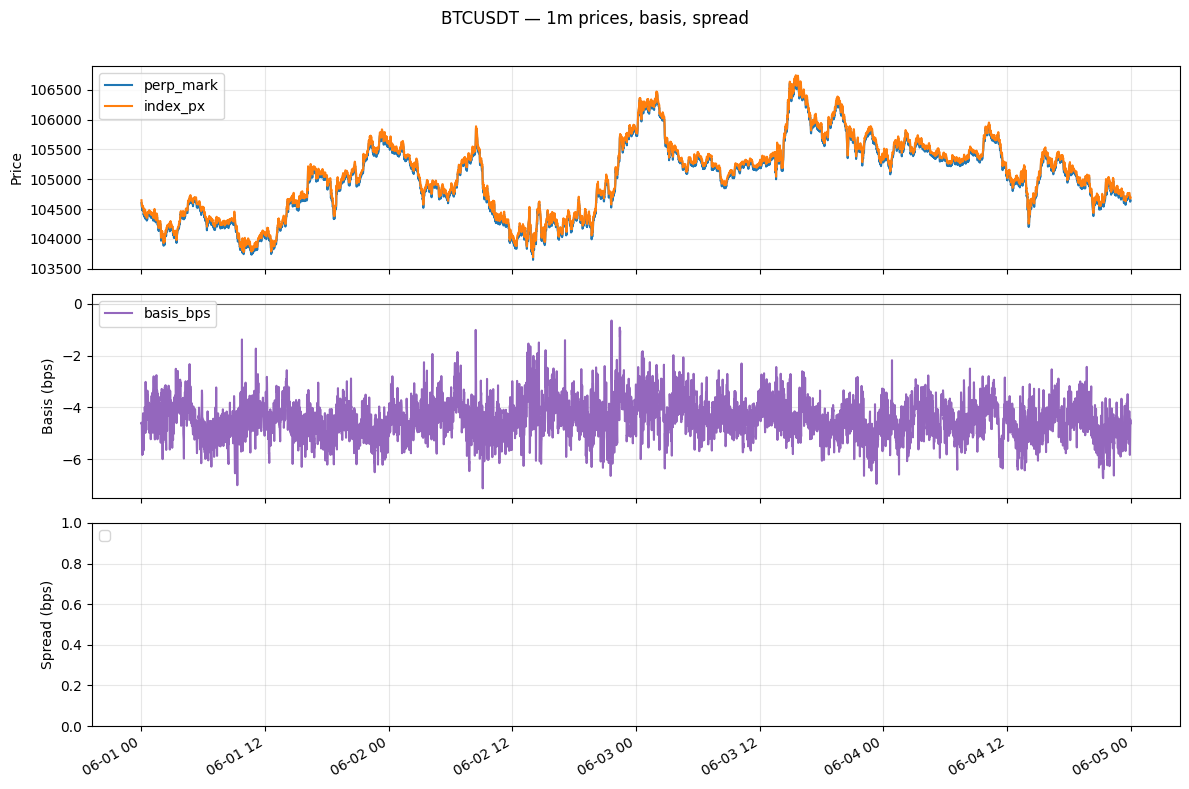

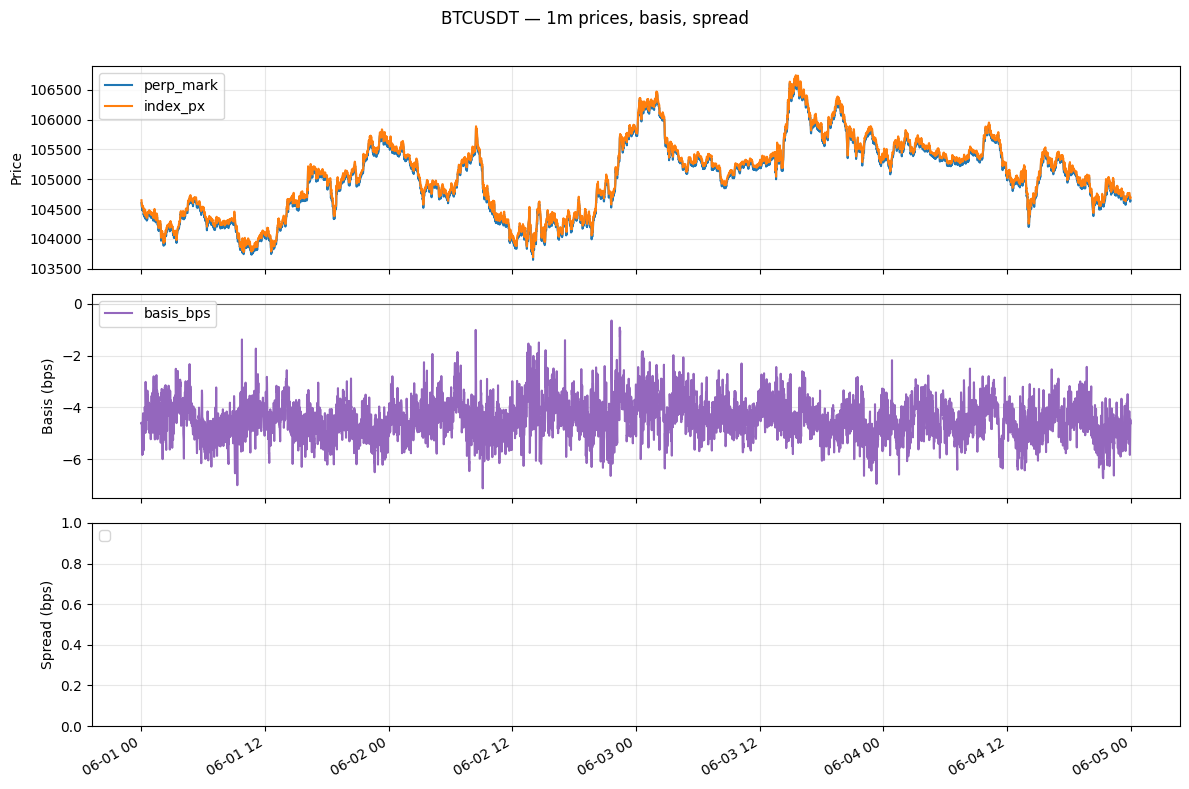

In [4]:
# Plot prices and basis (bps) with data_ok shading
fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
ax = axes[0]
for c in ['perp_mark','index_px']:
    if c in df1m.columns:
        ax.plot(df1m.index, df1m[c], label=c)
ax.set_ylabel('Price'); ax.legend(loc='upper left'); ax.grid(True, alpha=0.3)
ax = axes[1]
if {'perp_mark','index_px'}.issubset(df1m.columns):
    basis_bps = (df1m['perp_mark'] - df1m['index_px']) / df1m['index_px'] * 10000.0
    ax.plot(df1m.index, basis_bps, color='tab:purple', label='basis_bps'); ax.axhline(0, color='#666', lw=0.8)
ax.set_ylabel('Basis (bps)'); ax.legend(loc='upper left'); ax.grid(True, alpha=0.3)
ax = axes[2]
if 'spread_bps' in df1m.columns:
    ax.plot(df1m.index, df1m['spread_bps'], color='tab:orange', label='spread_bps')
ax.set_ylabel('Spread (bps)'); ax.legend(loc='upper left'); ax.grid(True, alpha=0.3)
if 'data_ok' in df1m.columns:
    mask = df1m['data_ok'].fillna(False).astype(bool)
    bad = (~mask).astype(int).diff().fillna((~mask).astype(int).iloc[0])
    starts = df1m.index[bad == 1]; ends = df1m.index[bad == -1]
    if len(ends) < len(starts): ends = ends.append(pd.Index([df1m.index[-1]]))
    for s, e in zip(starts, ends):
        for a in axes: a.axvspan(s, e, color='red', alpha=0.1)
fig.suptitle(f'{symbol} — 1m prices, basis, spread'); fig.autofmt_xdate(); fig.tight_layout(rect=[0,0,1,0.97]); fig

In [6]:
# Load features (5m)
p_feat = root / Path(paths['features_dir']) / symbol / 'features_5m.parquet'
df5 = pd.read_parquet(p_feat) if p_feat.exists() else pd.DataFrame()
df5.head(), df5.shape

(Empty DataFrame
 Columns: []
 Index: [],
 (0, 0))

In [ ]:
# Quick feature plots
cols = [c for c in ['basis_now','basis_TWAP_60m','premium_TWAP_120m','cvd_perp_15m','perp_share_60m','rv_15m'] if c in df5.columns]
n = max(1, len(cols))
fig, axes = plt.subplots(n, 1, figsize=(12, 2.4*n), sharex=True)
if n == 1: axes = [axes]
for i, c in enumerate(cols):
    axes[i].plot(df5.index, df5[c], label=c)
    axes[i].set_ylabel(c); axes[i].grid(True, alpha=0.3)
fig.suptitle(f'{symbol} — selected 5m features'); fig.autofmt_xdate(); fig.tight_layout(rect=[0,0,1,0.97]); fig

In [ ]:
# Overlay alerts if present
p_alerts = Path(paths['artifacts_dir']) / 'alerts' / f'{symbol}.csv'
alerts = pd.read_csv(p_alerts, parse_dates=['ts']) if p_alerts.exists() else pd.DataFrame()
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
if 'perp_mark' in df1m.columns: ax.plot(df1m.index, df1m['perp_mark'], label='perp_mark')
if not alerts.empty: ax.scatter(alerts['ts'], df1m.reindex(alerts['ts'])['perp_mark'], color='red', s=12, label='alerts')
ax.set_title(f'{symbol} — price with alerts'); ax.grid(True, alpha=0.3); ax.legend(loc='upper left'); fig